This notebook tries to answere this:
 
**2. How are YouTube channels interconnected, and what does this connectivity indicate about their influence and reach?**

**This part is only for the gaming category**

**Network Analysis within Gaming Category:**

We plan to identify key influencers and collaboration patterns in the Gaming category. The objective is to construct a network graph representing channels as nodes and collaborations as edges.
Then we will determine centrality measures to identify influential channels and analyze the frequency and scope of collaborations. To identify influential nodes and sub-networks in the games category we can use graph-theoretic measures (Louvain Community Detection). Visualization can be done through the application of NetworkX.

Sources: 
- https://memgraph.com/blog/community-detection-algorithms-with-python-networkx
- https://towardsdatascience.com/community-detection-algorithms-9bd8951e7dae


We have saved something as a pickle, so that we do not need to compute it everytime, this is parts that takes a lot of time. 
That is why they are commented out, but it is just to show the code. In addition, ploting the network-graph takes time.  

In [1]:
#Import 
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
import re
import seaborn as sns
import scipy.stats as stats
import os

# regression / matching
import statsmodels.formula.api as smf
import networkx as nx
from collections import defaultdict

In [2]:
# !pip install python-louvain

In [3]:
import matplotlib.cm as cm
from operator import itemgetter
import itertools

import warnings
warnings.filterwarnings('ignore')

In [4]:
import collections
from community import community_louvain

In [5]:
import operator
import random
import pickle

In [6]:
# !pip install plotly

In [7]:
import plotly.express as px
import plotly.graph_objs as go
from collections import defaultdict

In [8]:
color = sns.color_palette("husl",9)

**From milestone 2** We have 18.73 percent of rows where the collaborator ID is not NaN. This means that 18.73% of the videos that is published within the period has a collaborator within. We will now go into detail on the network of these collaborators. 


First part of notebook, we need to clean collaborators_per_week from Milestone 2, to get the a dataframe to make a network graph out of. 

In [9]:
#Define configuration-related variables 
DEFAULT_ENCODING = 'UTF8'
# Read in data
def read_csv(file, chunk_size=30000): 
    file_path = os.path.join("C:\\Users\\Bruker\\ADA_project\\", file)
    chunk_list = []  # List to hold chunks
    for chunk in pd.read_csv(file_path, encoding=DEFAULT_ENCODING, chunksize=chunk_size):
        chunk_list.append(chunk)
    # Concatenate chunks into single DataFrame, if the csv had been close to the ram, it would be clever to put it in the loop. 
    df = pd.concat(chunk_list, ignore_index=True)
    return df
df_collab_per_week = read_csv('collaborators_per_week.csv')
df_collab_per_week.copy()
display(df_collab_per_week)

,Year-Week,channel_id,collaborators_in_week
0,2016-00,UC-0Wg1wOUp-bRF1ZiC0dE8g,NaN
1,2016-00,UC-1pADhAUignVbTbVCW4Uuw,['UChm3iPolG6IVrIQ3bc6bIuQ' 'UCYFn32jjeY0Rx6jx...
2,2016-00,UC-3Oc4KY7pElZMbsWtm3X6A,NaN
3,2016-00,UC-3wJqf60YbC6jzAfPRm2ig,NaN
4,2016-00,UC-46hTnlyW3aCwjHs2acDzg,[None 'ARLNoble' 'xMattyG1' 'tiametmarduk1']
...,...,...,...
1872846,2019-42,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w
1872847,2019-43,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w
1872848,2019-44,UCRIxiOJN0Xd3evqxRu4iXew,['albertsunzheng' 'MrCasping']
1872849,2019-44,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w


In [10]:
#Remove all with a Nan in collaborators, so cut out the weeks where a channel did not have a collaborator
df_collab_per_week_nonNAN = df_collab_per_week.dropna(subset=['collaborators_in_week'])

# Step 1: Data Cleaning and Transformation
def clean_and_extract_ids(row):
    # Implement the cleaning and extraction logic here
    # Return a list of channel IDs
    list_channel_ids = []
    try:
        cleaned_row = row.replace("[", "").replace("]", "").replace("'", "").replace("\n", " ").replace("None", "")
        ids = cleaned_row.split()  # This splits the string on spaces
        for id in ids:
            list_channel_ids.append(id)
    except Exception as e:
        print(f"Error processing row: {row}. Error: {e}")
    return list_channel_ids


# Apply the function to each row and create a new column for extracted IDs
df_collab_per_week_nonNAN['extracted_collaborators'] = df_collab_per_week_nonNAN['collaborators_in_week'].apply(clean_and_extract_ids)

display(df_collab_per_week_nonNAN)


,Year-Week,channel_id,collaborators_in_week,extracted_collaborators
1,2016-00,UC-1pADhAUignVbTbVCW4Uuw,['UChm3iPolG6IVrIQ3bc6bIuQ' 'UCYFn32jjeY0Rx6jx...,"[UChm3iPolG6IVrIQ3bc6bIuQ, UCYFn32jjeY0Rx6jxd_..."
4,2016-00,UC-46hTnlyW3aCwjHs2acDzg,[None 'ARLNoble' 'xMattyG1' 'tiametmarduk1'],"[ARLNoble, xMattyG1, tiametmarduk1]"
7,2016-00,UC-AVK_NtJg6aSYAeEbYnfIw,theDarkElfX,[theDarkElfX]
8,2016-00,UC-BG8jc9gI_BpobNXldQuFw,['morachi24' 'BSquaredHD'],"[morachi24, BSquaredHD]"
18,2016-00,UC-WA0qTCwuMCd418q_6xbEg,krypto9095,[krypto9095]
...,...,...,...,...
1872846,2019-42,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w,[UC0p1OMeCD9OPNmIWCfqdJ7w]
1872847,2019-43,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w,[UC0p1OMeCD9OPNmIWCfqdJ7w]
1872848,2019-44,UCRIxiOJN0Xd3evqxRu4iXew,['albertsunzheng' 'MrCasping'],"[albertsunzheng, MrCasping]"
1872849,2019-44,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w,[UC0p1OMeCD9OPNmIWCfqdJ7w]


In [11]:
#Rest index
df_collab_per_week_nonNAN_index_reset = df_collab_per_week_nonNAN.reset_index()

#We saw that some people listed the same channels 150 times, in the same week, this gives a unreal distribution of our network
#If he not made that much videos in that week. 
#Example
print(df_collab_per_week_nonNAN_index_reset.iloc[1854].loc['extracted_collaborators'][:30])


def remove_duplicates(collab_list):
    """
    Return a list with only unique items.
    """
    return list(set(collab_list))


# Apply the function to the 'extracted_collaborators' column
df_collab_per_week_nonNAN_index_reset['unique_collaborators'] = df_collab_per_week_nonNAN_index_reset['extracted_collaborators'].apply(remove_duplicates)


display(df_collab_per_week_nonNAN_index_reset[df_collab_per_week_nonNAN_index_reset['channel_id']=='UCgc8PshAGngxCLCMfoy8NpQ'])

['PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile']


,index,Year-Week,channel_id,collaborators_in_week,extracted_collaborators,unique_collaborators
1854,6752,2016-01,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...","[PlayscopeHD, playscopemobile, PlayscopeTimeline]"
3594,12880,2016-02,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...","[PlayscopeHD, playscopemobile, PlayscopeTimeline]"
5388,19138,2016-03,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...","[PlayscopeHD, playscopemobile, PlayscopeTimeline]"
7199,25472,2016-04,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...","[PlayscopeHD, playscopemobile, PlayscopeTimeline]"
9031,31841,2016-05,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...","[PlayscopeHD, playscopemobile, PlayscopeTimeline]"
...,...,...,...,...,...,...
459852,1829452,2019-35,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeTrailers' 'PlayscopeTrailers' 'Play...,"[PlayscopeTrailers, PlayscopeTrailers, Playsco...",[PlayscopeTrailers]
462317,1840028,2019-36,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeTrailers' 'PlayscopeTrailers' 'Play...,"[PlayscopeTrailers, PlayscopeTrailers, Playsco...",[PlayscopeTrailers]
464771,1850573,2019-37,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeTrailers' 'PlayscopeTrailers' 'Play...,"[PlayscopeTrailers, PlayscopeTrailers, Playsco...",[PlayscopeTrailers]
467230,1861124,2019-38,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeTrailers' 'PlayscopeTrailers' 'Play...,"[PlayscopeTrailers, PlayscopeTrailers, Playsco...",[PlayscopeTrailers]


In [12]:
#Find channels with most unique collaborations: 
df_collab_per_week_nonNAN_index_reset['num_collaborators'] = df_collab_per_week_nonNAN_index_reset['unique_collaborators'].apply(len)
# Group by 'channel_id' and sum the 'num_collaborators' for each unique channel
aggregated_collaborators_df = df_collab_per_week_nonNAN_index_reset.groupby('channel_id')['num_collaborators'].sum().reset_index()

# Rename the summed column to 'total_collaborators'
aggregated_collaborators_df.rename(columns={'num_collaborators': 'total_collaborators'}, inplace=True)
aggregated_collaborators_df.sort_values(by = 'total_collaborators',ascending=False).head(10)

,channel_id,total_collaborators
3556,UCBw-Dz6wHRkxiXKCLoWqDzA,13291
5504,UCIciwR-CmXsaunrGw2DBjhA,5904
17519,UCxTjqtGRSkfhfnLp52ggcrA,4209
14892,UCo5fwkuD4XQi33vIpbi886w,3230
13289,UCimN5mkyHUmO3oQsU7c4uYQ,2687
5158,UCHSI8erNrN6hs3sUK6oONLA,2632
2031,UC6LYaCnVf9l-kIuVg2pPTHg,2433
17030,UCvaCEaGOHviqTIxzYKpcSLg,2394
1004,UC2_LJGtXaD9B8hsmXLj4IRw,2243
18254,UCzz9_nzdbrxnErTZPZdZ-cw,2215


count    18259.000000
mean        64.209376
std        193.155513
min          1.000000
25%          3.000000
50%         12.000000
75%         53.000000
max      13291.000000
Name: total_collaborators, dtype: float64


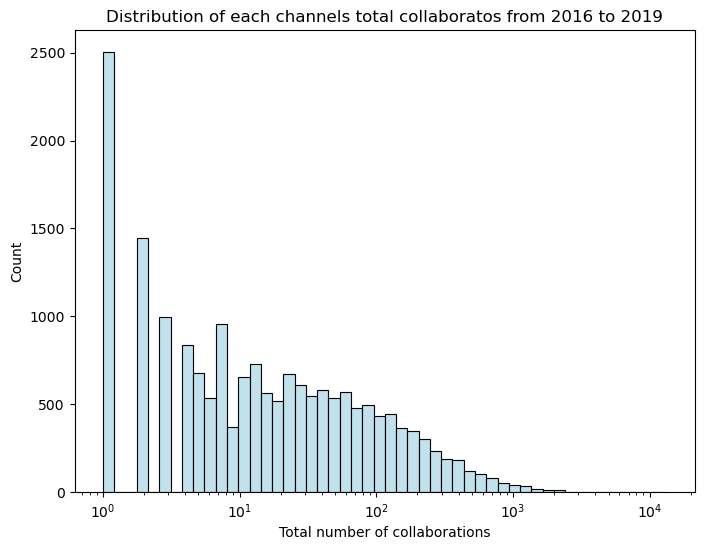

In [13]:
#The distribution of collaborators: 
print(aggregated_collaborators_df['total_collaborators'].describe())

# Histogram with adjusted bins and log scale
plt.figure(figsize=(8, 6))
sns.histplot(aggregated_collaborators_df, x="total_collaborators", bins=50, color='lightblue',log_scale=True)
plt.xlabel('Total number of collaborations')
plt.title('Distribution of each channels total collaboratos from 2016 to 2019')
plt.savefig('Total_collaborators.png')
plt.show()

**Making the network** 
1) Make the edge list 
2) Assigne a network, but our edgelist is so big so we need to bootstrap the edge list to create a graph plot.   

In [14]:
# # Function to create edges from a row
# def create_edges(row):
#     return list(product([row['channel_id']], row['unique_collaborators']))

# chunk_size = 5000
# edges = []

# for start in range(0, len(df_collab_per_week_nonNAN_index_reset), chunk_size):
#     chunk = df_collab_per_week_nonNAN_index_reset.iloc[start:start + chunk_size]
#     chunk_edges = chunk.apply(create_edges, axis=1).explode().tolist()
#     edges.extend(chunk_edges)

# print(edges[:10])
# print(np.shape(edges))

In [15]:
# Define the filename and path for the pickle file
# pickle_filename = 'edges_pickle.pkl' 

# # Serialize and save the edges list to a file
# with open(pickle_filename, 'wb') as file:
#     pickle.dump(edges, file)

In [16]:
#Helper function from excersice 11: 

def plot_log_log_degree_distribution(G):
    # Collect all degrees in the graph
    all_degrees = [G.degree(node) for node in G.nodes() if G.degree(node) > 0]  # Exclude zero-degree nodes

    # Define the number of bins
    num_bins = 50  # You can adjust this number as needed

    # Create logarithmically spaced bins
    log_bins = np.logspace(np.log10(min(all_degrees)), np.log10(max(all_degrees)), num=num_bins)

    # Plot the histogram
    fig, ax = plt.subplots()
    sns.histplot(all_degrees, bins=log_bins, edgecolor='black',color='lightblue')
    plt.title("Degree Distribution (Log-Log scale)")
    plt.ylabel("Frequency")
    plt.xlabel("Number of collaborators")
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

# Helper function for printing various graph properties
def describe_graph(G):
    print(G)
    if nx.is_connected(G):
        print("Avg. Shortest Path Length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
    print("Sparsity: %.4f" %nx.density(G))  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))

# Helper function for visualizing the graph
def visualize_graph(G, with_labels=True, k=None, alpha=1.0, node_shape='o'):
    #nx.draw_spring(G, with_labels=with_labels, alpha = alpha)
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color='g', node_shape=node_shape)
    plt.axis('off')

In [17]:
with open('edges_pickle.pkl', 'rb') as f:
    edges = pickle.load(f)

print(edges[:10])

[('UC-1pADhAUignVbTbVCW4Uuw', 'UCj8pJC0ONCz5zClAewsbSOw'), ('UC-1pADhAUignVbTbVCW4Uuw', 'UChm3iPolG6IVrIQ3bc6bIuQ'), ('UC-1pADhAUignVbTbVCW4Uuw', 'UCYFn32jjeY0Rx6jxd_b_QQA'), ('UC-46hTnlyW3aCwjHs2acDzg', 'ARLNoble'), ('UC-46hTnlyW3aCwjHs2acDzg', 'tiametmarduk1'), ('UC-46hTnlyW3aCwjHs2acDzg', 'xMattyG1'), ('UC-AVK_NtJg6aSYAeEbYnfIw', 'theDarkElfX'), ('UC-BG8jc9gI_BpobNXldQuFw', 'morachi24'), ('UC-BG8jc9gI_BpobNXldQuFw', 'BSquaredHD'), ('UC-WA0qTCwuMCd418q_6xbEg', 'krypto9095')]


In [18]:
# Done ones 
# G = nx.Graph()
# # Assuming 'edges' is a column in df that contains edge tuples
# G.add_edges_from(edges)

# with open('your_networkx_graph.pkl', 'wb') as f:
#     pickle.dump(G, f)

In [19]:
with open('your_networkx_graph.pkl', 'rb') as f:
    G = pickle.load(f)
describe_graph(G)


Graph with 201936 nodes and 297276 edges
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0000
Global clustering coefficient aka Transitivity: 0.0021


In [20]:
#This takes a lot of time: 
print(f"Average degree in overall Graph: {sum(dict(G.degree()).values()) / float(G.number_of_nodes()):.4f}")

sorted_nodes_by_degree = sorted(G.degree, key=lambda x: x[1], reverse=True)

print("First stats about total connections:")
# Top 10 nodes with the most connections
top_10_nodes = sorted_nodes_by_degree[:10]
for node, degree in top_10_nodes:
    print(f"Node {node} has {degree} connections")

Average degree in overall Graph: 2.9443
First stats about total connections:
Node UCBw-Dz6wHRkxiXKCLoWqDzA has 11422 connections
Node UCIciwR-CmXsaunrGw2DBjhA has 3351 connections
Node UCxTjqtGRSkfhfnLp52ggcrA has 2838 connections
Node UCN-v-Xn9S7oYk0X2v1jx1Qg has 1779 connections
Node UCWVuy4NPohItH9-Gr7e8wqw has 1702 connections
Node UCvaCEaGOHviqTIxzYKpcSLg has 1676 connections
Node UC6LYaCnVf9l-kIuVg2pPTHg has 1592 connections
Node UCo5fwkuD4XQi33vIpbi886w has 1525 connections
Node UC2_LJGtXaD9B8hsmXLj4IRw has 1237 connections
Node UCv5gQgP_uGbJxImWVoUC_Ng has 1145 connections


In [21]:
def bootstrap_edges(edges, n_bootstrap, sample_size):
    """
    Generate n_bootstrap bootstrapped samples of the edge list.
    """
    bootstrapped_samples = []
    for _ in range(n_bootstrap):
        sampled_edges = [random.choice(edges) for _ in range(sample_size)]
        bootstrapped_samples.append(sampled_edges)
    return bootstrapped_samples


bootstrapped_edge_lists = bootstrap_edges(edges, n_bootstrap=50, sample_size=10000)

In [22]:
# Create a dictionary to count the occurrence of each edge across all bootstrapped samples
edge_frequency = defaultdict(int)

for bootstrapped_edges in bootstrapped_edge_lists:
    for edge in bootstrapped_edges:
        # Sort the tuple to avoid duplicate edges in different orders
        sorted_edge = tuple(sorted(edge))
        edge_frequency[sorted_edge] += 1

# Convert counts to probabilities
total_samples = len(bootstrapped_edge_lists)
edge_probability = {edge: count/total_samples for edge, count in edge_frequency.items()}

# Set a threshold for including an edge
threshold = 0.2  

# Create a new edge list that includes edges meeting the threshold
representative_edges = [edge for edge, probability in edge_probability.items() if probability >= threshold]


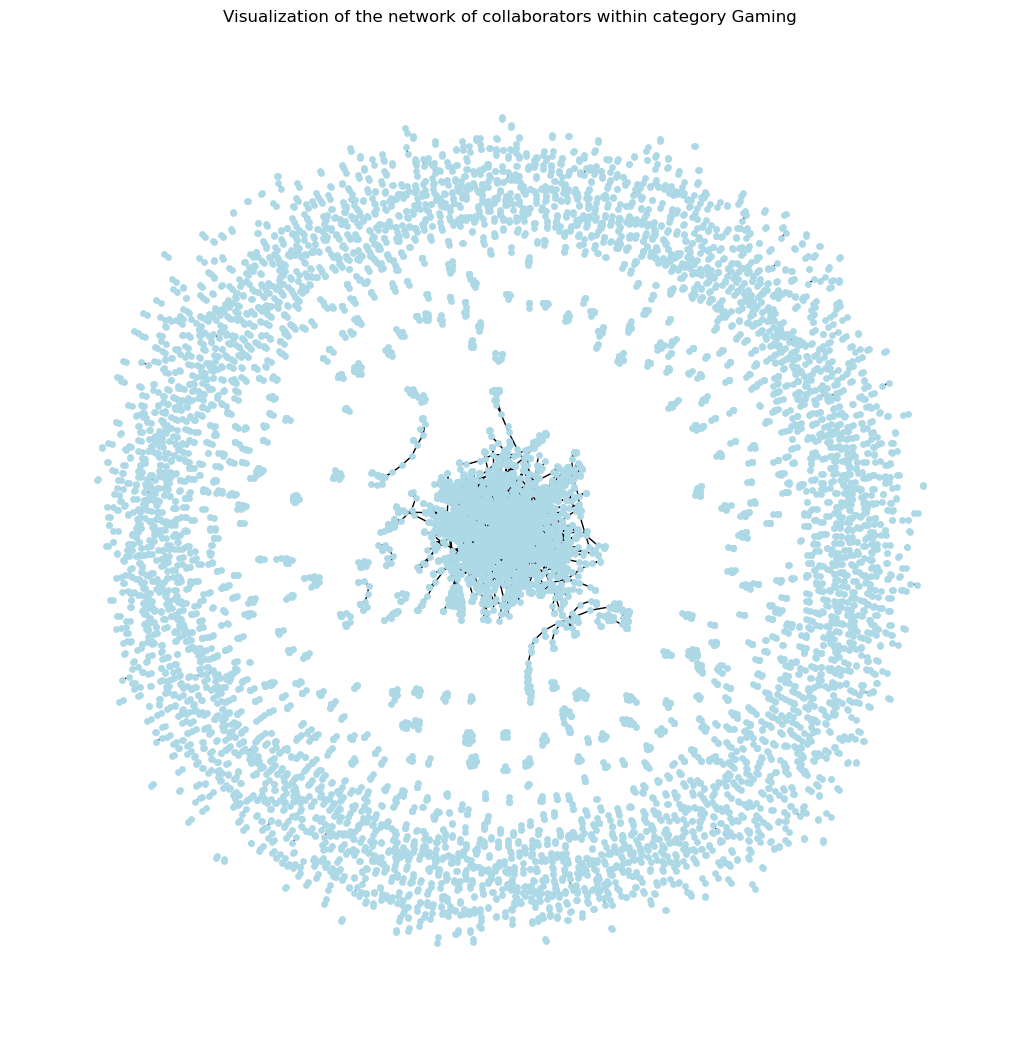

In [23]:
G_bootstrapped = nx.Graph()
G_bootstrapped.add_edges_from(representative_edges)

plt.figure(figsize=(10, 10))
nx.draw(G_bootstrapped, node_size=15, edge_color="black", node_color='lightblue',with_labels=False)
plt.title("Visualization of the network of collaborators within category Gaming")
plt.savefig("Bootstrapped_network.png")
plt.show()

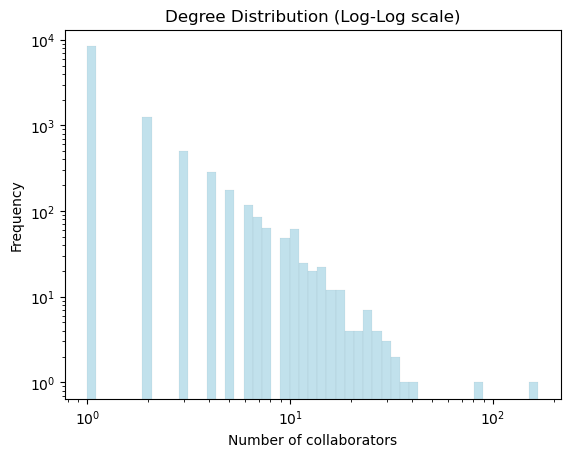

<Figure size 640x480 with 0 Axes>

In [24]:
degree_distribution = plot_log_log_degree_distribution(G_bootstrapped)
plt.savefig('degree_distribtuion.png')

**Decsribing the network**

We then move on to decsribing the network, with methodes learned in class. 

In [25]:
#From https://github.com/epfl-ada/2023/tree/main/Exercises/10%20-%20Handling%20networks
#G_bootstrapped
print("Network sparsity: %.4f" %nx.density(G_bootstrapped))
print(nx.is_connected(G_bootstrapped))
comp = list(nx.connected_components(G_bootstrapped))
print('The graph contains', len(comp), 'connected components')
largest_comp_b = max(comp, key=len)
percentage_lcc_b = len(largest_comp_b)/G_bootstrapped.number_of_nodes() * 100
print('The largest component has', len(largest_comp_b), 'nodes', 'accounting for %.2f'% percentage_lcc_b, '% of the nodes') 
print('%.4f' %nx.transitivity(G_bootstrapped))

Network sparsity: 0.0002
False
The graph contains 2620 connected components
The largest component has 2924 nodes accounting for 26.37 % of the nodes
0.0429


In [26]:
#From https://github.com/epfl-ada/2023/tree/main/Exercises/10%20-%20Handling%20networks
degrees = dict(G_bootstrapped.degree(G_bootstrapped.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)

# And the top 5 most popular quakers are.. 
for channel, degree in sorted_degree[:5]:
    print(channel, 'who is connected to', degree, 'channels')

NoCopyrightSounds who is connected to 167 channels
CHUKImusic who is connected to 85 channels
UC_aEa8K-EOJ3D6gOs7HcyNg who is connected to 40 channels
UCimN5mkyHUmO3oQsU7c4uYQ who is connected to 35 channels
UCKLAF4CTNw4Mv3ecLExroQA who is connected to 34 channels


In [27]:
# #G_bootstrapped
# betweenness_b = nx.betweenness_centrality(G_bootstrapped)
# # Assign the computed centrality values as a node-attribute in your network
# nx.set_node_attributes(G_bootstrapped, betweenness_b, 'betweenness')
# sorted_betweenness_b = sorted(betweenness_b.items(), key=itemgetter(1), reverse=True)

# # Save the betweenness centrality to a pickle file
# with open('betweenness_centrality_b.pkl', 'wb') as f:
#     pickle.dump(betweenness_b, f)

In [28]:
#open bootstrapped: 
with open('betweenness_centrality_b.pkl', 'rb') as f:
    betweenness_b = pickle.load(f)

sorted_betweenness_b = sorted(betweenness_b.items(), key=itemgetter(1), reverse=True)

for channel, bw in sorted_betweenness_b[:5]:
    print(f"{channel}, who has betweenness: {bw:.3f}")

NoCopyrightSounds, who has betweenness: 0.036
CHUKImusic, who has betweenness: 0.012
UC-nL_2TP09QuovUwqg6CUOQ, who has betweenness: 0.009
UC_aEa8K-EOJ3D6gOs7HcyNg, who has betweenness: 0.009
Cheridet, who has betweenness: 0.008


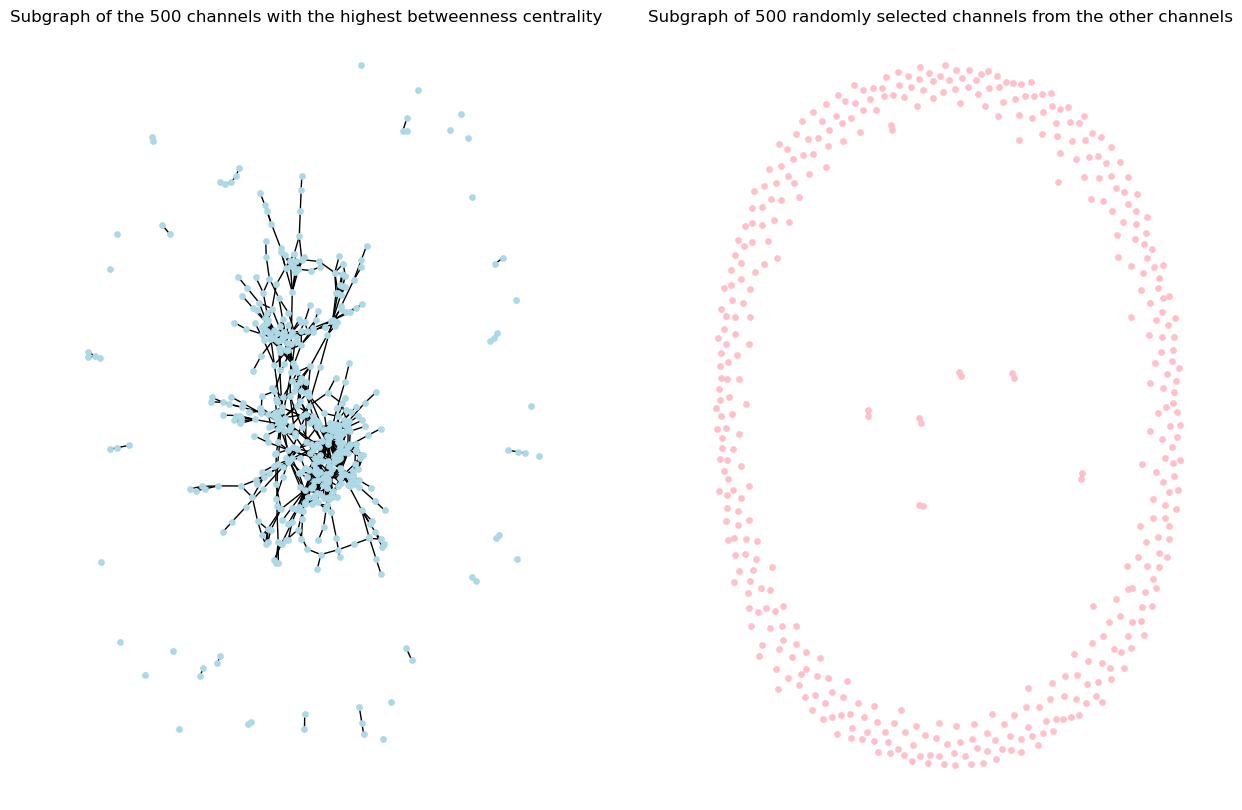

In [50]:
sorted_nodes_by_degree = sorted(betweenness_b.items(), key=operator.itemgetter(1), reverse=True)

# Sort nodes by their betweenness centrality and get the top 500
top_betweenness_nodes = sorted_nodes_by_degree[:500]
top_betweenness_nodes = [node for node, _ in top_betweenness_nodes]

# Create a subgraph with these top nodes
subgraph_betweenness = G_bootstrapped.subgraph(top_betweenness_nodes)

#Do the same for the rest of the nodes
rest_of_the_nodes = [node for node, _ in sorted_nodes_by_degree[500:]]
rest_of_the_nodes_random = random.sample(rest_of_the_nodes, 500)

# Create a subgraph with the random nodes
subgraph_random = G_bootstrapped.subgraph(rest_of_the_nodes_random)

# Visualize the subgraphs as a two subplot
plt.figure(figsize=(15, 10))

# Left plot - Top 500 nodes by betweenness centrality
plt.subplot(1, 2, 1)
nx.draw(subgraph_betweenness, node_size=15, with_labels=None, node_color='lightblue', edge_color='black')
plt.title("Subgraph of the 500 channels with the highest betweenness centrality")

# Right plot - Random 10 nodes from the rest
plt.subplot(1, 2, 2)
nx.draw(subgraph_random, node_size=15, with_labels=None, node_color='pink', edge_color='black')
plt.title("Subgraph of 500 randomly selected channels from the other channels")
plt.savefig('Showing_network.png')
plt.show()

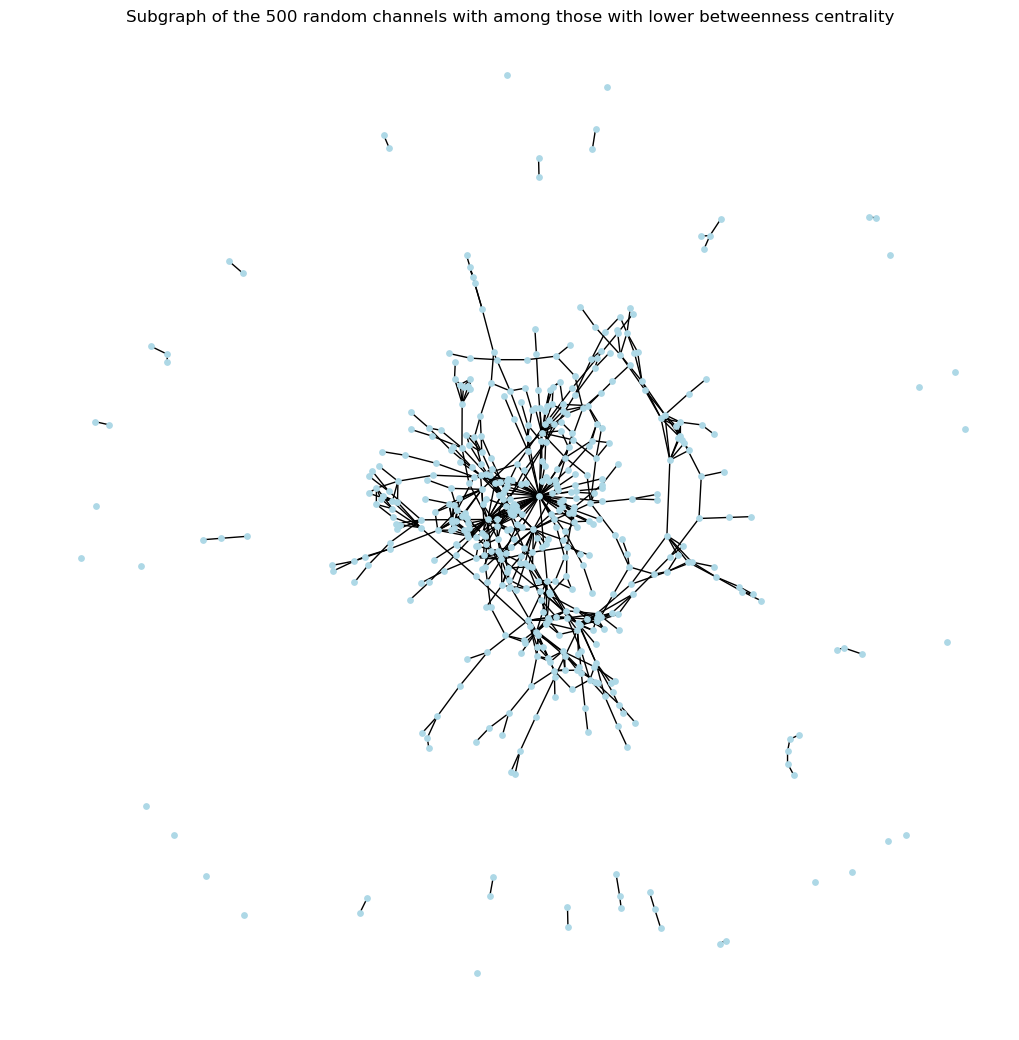

In [30]:
# Sort nodes by their betweenness centrality and get the top 500
top_betweenness_nodes = sorted(betweenness_b.items(), key=operator.itemgetter(1), reverse=True)[:500]
top_betweenness_nodes = [node for node, _ in top_betweenness_nodes]

# Create a subgraph with these top nodes
subgraph_betweenness = G_bootstrapped.subgraph(top_betweenness_nodes)

# Visualize the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph_betweenness, node_size = 15, with_labels=None, node_color='lightblue', edge_color='black')
plt.title("Subgraph of the 500 random channels with among those with lower betweenness centrality")
plt.savefig("")
plt.show()

In [31]:
# Eigenvector centrality - why did this fail?: 
# G_bootstrapped_eigenvector = nx.eigenvector_centrality(G_bootstrapped)

# G_bootstrapped_eigenvector_s = sorted(G_bootstrapped_eigenvector.items(), key=lambda item: item[1], reverse=True)
# print(G_bootstrapped_eigenvector_s)

#closness centrality: 
G_bootstrapped_closness = nx.closeness_centrality(G_bootstrapped)

G_bootstrapped_closness = sorted(G_bootstrapped_closness.items(), key=lambda item: item[1], reverse=True)

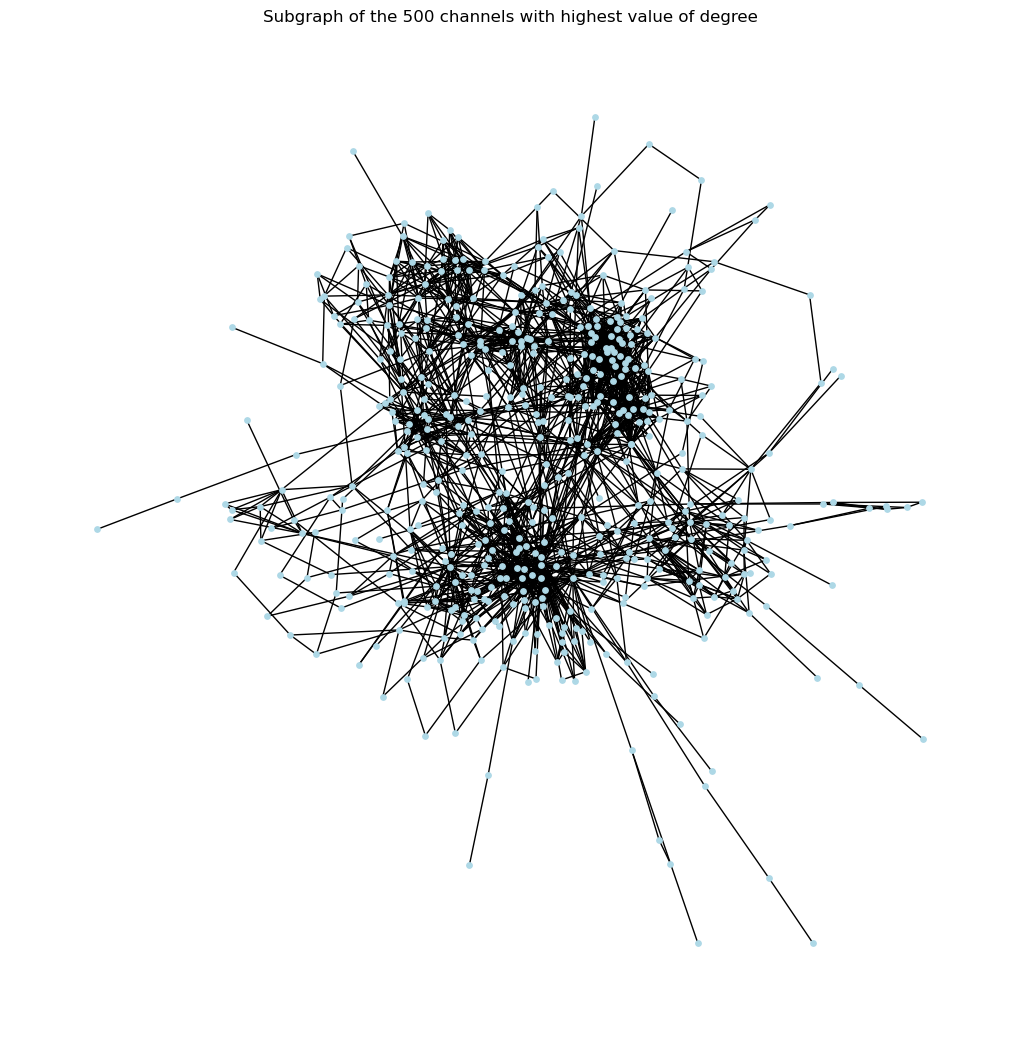

In [32]:
# Extract just the nodes for the top 100

top_500_nodes = [node for node, degree in sorted_nodes_by_degree[:500]]
subgraph_top_500 = G.subgraph(top_500_nodes)

# Visualize the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph_top_500,node_size=15, with_labels=None, node_color='lightblue', edge_color='black')
plt.title("Subgraph of the 500 channels with highest value of degree")
plt.show()

In [33]:

partition = community_louvain.best_partition(subgraph_top_500)
# add it as an attribute to the nodes
for n in subgraph_top_500.nodes:
    subgraph_top_500.nodes[n]["louvain"] = partition[n]


In [34]:
#link: https://plotly.com/python/network-graphs/
# Calculate layout for our nodes 
pos = nx.spring_layout(subgraph_top_500, k=0.2)

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in subgraph_top_500.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += (x0, x1, None)
    edge_trace['y'] += (y0, y1, None)

# Create node trace
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=False,  # Set showscale to False to hide the colorbar
        colorscale='Jet',
        color=[subgraph_top_500.nodes[node]["louvain"] for node in subgraph_top_500.nodes],
        size=10,
        line_width=2))

# Add node positions to the node trace
for node in subgraph_top_500.nodes():
    x, y = pos[node]
    node_trace['x'] += (x,)
    node_trace['y'] += (y,)
    node_info = f"# of Collaborators: {subgraph_top_500.degree(node)}"
    node_trace['text'] += (node_info,)

# Create figure
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph of the 500 channels with most collaborators',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[{
                    "text": "Hover to see the number of collaborators",
                    "showarrow": False,
                    "xref": "paper",
                    "yref": "paper",
                    "x": 0.005,
                    "y": -0.002 
                }],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

# Show the figure
fig.show()

fig.write_html('Total_collaborators.html')


**Finding how they are collaborating with**

1) Load dataframes, to find the ones outside gaming
2) Need to work on the dateframe 

In [35]:
def read_csv(file, chunk_size=30000): 
    file_path = os.path.join("C:\\Users\\Bruker\\ADA_project\\", file)
    chunk_list = []  # List to hold chunks
    for chunk in pd.read_csv(file_path, encoding=DEFAULT_ENCODING, chunksize=chunk_size):
        chunk_list.append(chunk)
    # Concatenate chunks into single DataFrame, if the csv had been close to the ram, it would be clever to put it in the loop. 
    df = pd.concat(chunk_list, ignore_index=True)
    return df

df_collab_videos = read_csv('dataframe_collaborations_videos.csv')
display(df_collab_videos)



,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,upload_date,view_count,final_collaborator_ids
0,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:25.790269,0.0,y5IvyZlzELs,3442,9.0,2016-09-26,1253.0,NaN
1,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:28.334071,0.0,m1agc0qT0BY,2407,8.0,2016-09-25,2311.0,NaN
2,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:32.174979,1.0,rr6tfbBA9iY,1820,11.0,2016-09-24,5596.0,NaN
3,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:25.379061,0.0,ZGll5_wD9Ys,1209,8.0,2016-09-21,792.0,NaN
4,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:26.020550,426.0,kYkokQgnu20,2053,2076.0,2016-09-21,1141393.0,NaN
...,...,...,...,...,...,...,...,...,...,...
9166272,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:06.375078,12.0,s6mBrPKvumc,558,368.0,2018-09-26,10397.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166273,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:07.025547,16.0,qneHrPX4_AY,363,574.0,2018-09-25,13954.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166274,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:07.684503,32.0,4H4Oz0Rjd70,713,596.0,2018-09-24,24198.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166275,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:08.371065,65.0,c_34mr0tXDk,1306,1301.0,2018-09-23,93020.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."


In [36]:
# Group by 'channel_id' and sum the 'view_count'
agg_df = df_collab_videos.groupby('channel_id')['view_count'].sum().reset_index()

# Rename columns for clarity
agg_df.columns = ['channel_id', 'total_views']

# Now agg_df is your desired DataFrame
display(agg_df.head(10))
display(agg_df[agg_df['channel_id']=='FlockOfNerdsdotCom'])

,channel_id,total_views
0,UC--7oyGW0N7fMf164-ZXljQ,1375099.0
1,UC--b720KocplK9zh0peruqg,943339.0
2,UC--oOv_2PpzwK4WNsjG2UAw,2891.0
3,UC--szL7ECbL2jmnOpx6BrNg,2161.0
4,UC--vL4ZYLa0bi3TQcuwrhoA,8044163.0
5,UC-05oNebNywp5jy7iXZWZzA,985856.0
6,UC-07j8SBVA5mHbiNWe2-jcw,23055.0
7,UC-0Wg1wOUp-bRF1ZiC0dE8g,10536233.0
8,UC-0xJTkutOCoRoBi3YOkHRg,5445631.0
9,UC-10uJUkzxSXa9sEtV67YcA,10137899.0


,channel_id,total_views


What we see is that a lot of the collaboarations happens with people that are not within the gaming category. 
From the edges list, check how has a channel_id within the df_collab_videos[channel_id] column, if not make me a list of the ones that are within and the ones that are outside. 

In [37]:
# Extract unique channel IDs from edges
unique_channels_in_edges = set([channel for edge in edges for channel in edge])

# Channels within the gaming category
channels_within = set(df_collab_videos['channel_id'])

# Determine channels in edges that are within and outside the gaming category
channels_within_category = unique_channels_in_edges.intersection(channels_within)
channels_outside_category = unique_channels_in_edges.difference(channels_within)

# Convert sets to lists (optional, depending on your further use)
channels_within_category_list = list(channels_within_category)
channels_outside_category_list = list(channels_outside_category)


In [38]:
#Use raw to find the views for the channels: "C:\Users\Bruker\ADA2023\Project\_raw_df_timeseries.tsv.gz"
# Create a set of channel IDs from the DataFrame

channels_in_df = set(df_collab_videos['channel_id'])

# New edges list with both channel IDs in the DataFrame
new_edges_within = [(ch1, ch2) for ch1, ch2 in edges if ch1 in channels_in_df and ch2 in channels_in_df]

# Edges list with at least one channel ID outside the DataFrame
edges_outside = [(ch1, ch2) for ch1, ch2 in edges if ch1 not in channels_in_df or ch2 not in channels_in_df]

The following plots was done with help of https://plotly.com/python/network-graphs/ and OPENAI - CHATGPT 4

In [39]:
num_edges_within = len(new_edges_within)
num_edges_outside = len(edges_outside)

# Data to plot
labels = ['Collaborations Within', 'Collaborations Outside']
values = [num_edges_within, num_edges_outside]
colors = ['lightblue', 'lightgreen']

# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.3)])

# Customize the layout and colors
fig.update_traces(marker=dict(colors=colors), textinfo='percent+label')
fig.update_layout(
    title_text='Proportion of Collaborations Within vs Outside the Original DataFrame',
    annotations=[dict(text='Collaborations', x=0.5, y=0.5, font_size=20, showarrow=False)]
)

# Show the figure
fig.show()

# Save the plot to an HTML file (optional)
fig.write_html('Collaborations_Proportion.html')

Graph with 2821 nodes and 2139 edges
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0005
Global clustering coefficient aka Transitivity: 0.1508


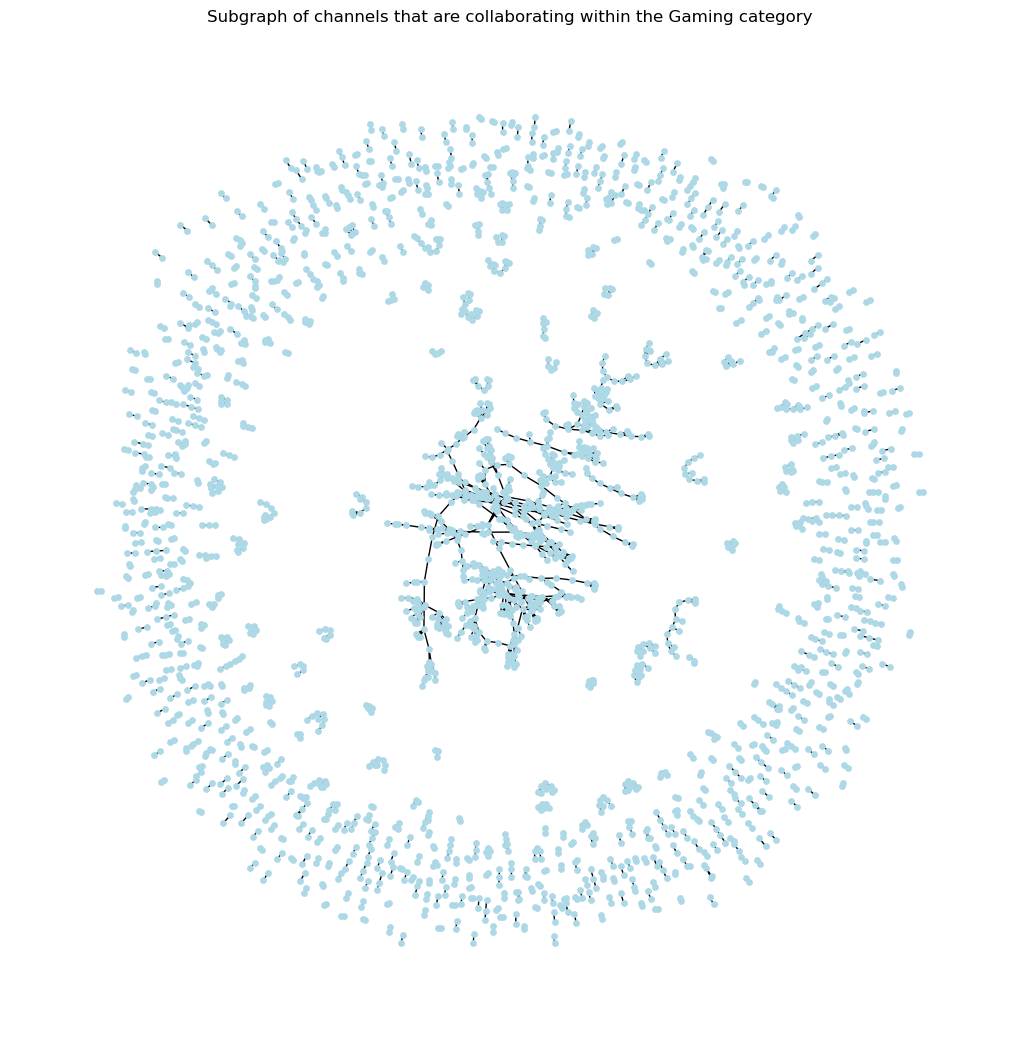

In [40]:
new_edges_within_random = random.sample(new_edges_within, 3000)
#Should i make if to the whole?? Make it interactive? 

G_within = nx.Graph()
G_within.add_edges_from(new_edges_within_random)


describe_graph(G_within)

# plot it out
# Visualize the subgraph
plt.figure(figsize=(10, 10))
nx.draw(G_within, with_labels=None, node_size=15, node_color = 'lightblue',edge_color='black')
plt.title("Subgraph of channels that are collaborating within the Gaming category")
plt.savefig("collaboration_withing_gaming.png")
plt.show()

In [41]:
channels_path = "C:\\Users\\Bruker\\ADA2023\\Project\\_raw_df_channels.tsv\\df_channels.tsv"

# Define the start and end dates of our study
start_date = pd.Timestamp('2016-01-01')
end_date = pd.Timestamp('2019-12-31')

### loading datasets
df_channels = pd.read_csv(channels_path, sep ='\t')

# convert dates into datetime format
df_channels['join_date'] = pd.to_datetime(df_channels['join_date'])

# only keep data within the dates of interest for our study
df_channels.drop(df_channels[df_channels.join_date > end_date].index, inplace=True)

display(df_channels)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb
0,Film and Animation,2017-05-21,UCBJuEqXfXTdcPSbGO9qqn1g,MagnusNation,65100,28,231223.0
1,Entertainment,2011-12-13,UCkNW9Q1VR_aeZ6uht83jJVQ,Mago Dario Animazion...,60200,48,238538.0
2,Music,2008-03-17,UCXhkGgooXHDNwgJXmoTSN7g,Mago Merlino,14800,838,707828.0
3,Entertainment,2014-10-19,UCvZGsuvKlYOGiZTsxwJNS5Q,MAGO TOMÁS,26200,31,424550.0
4,Comedy,2017-01-15,UCxJWPpPED-J24znoKyKZYjg,Magog of Morskar,29400,158,422966.0
...,...,...,...,...,...,...,...
156972,Gaming,2008-08-18,UCEqenmVLMGDN5yvbEQeaC7w,Elajjaz,97200,432,165917.0
156973,Autos & Vehicles,2006-05-09,UC-RZIjGh-BMEfzY1gb3XCCg,ElaKiri,154000,72,101165.0
156974,Gaming,2017-07-02,UCcU43L4KBWYqMP5suA3DUDA,ElAlejo,11400,17,NaN
156975,Music,2015-09-26,UCEU5ZK7DwN9ppqPFJiGah3A,ElAlfaElJefeTV,2720000,84,NaN


In [42]:
#To do analysis if their is a difference between the ones with highest degree and the rest, we need to modify the dataframes. It is done in the next four following cells. 
# Group by 'channel_id' and sum the 'view_count'
agg_df_2 = df_channels.groupby('channel')['subscribers_cc'].sum().reset_index()
agg_df_2['name_cc'] = df_channels['name_cc']
agg_df_2['category_cc'] = df_channels['category_cc']

agg_df_2_gaming = agg_df_2[agg_df_2['category_cc'].isin(['Gaming'])]
agg_df_2.columns = ['channel_id', 'subscribers_cc','name_cc','category_cc']
 

In [63]:
# Randomly sample 10 from the top 100
top_50_nodes = [node for node, degree in sorted_nodes_by_degree[:50]]
random_10_from_top_50 = random.sample(top_50_nodes, 10)

# Get the rest of the nodes (all nodes except the top 100, but not to small, since then they are not visible in the dataset)
rest_of_the_nodes = [node for node, degree in sorted_nodes_by_degree[100:10000]]

# Randomly sample 10 from the rest of the nodes
random_10_from_rest = random.sample(rest_of_the_nodes, 10)


In [64]:
#The rest are usually real channels, but we need to have a higher treshhold, since these channels are to low. 

top_df = agg_df_2[(agg_df_2['channel_id'].isin(random_10_from_top_50)) | (agg_df_2['name_cc'].isin(random_10_from_top_50))]
top_df['Group'] = 'Top'

# Create a DataFrame for the rest of the channels
# Check if the channel_id or name is in rest_channels
rest_df = agg_df_2[(agg_df_2['channel_id'].isin(random_10_from_rest)) | (agg_df_2['name_cc'].isin(random_10_from_rest))]
rest_df['Group'] = 'Rest'

# Combine the two DataFrames
combined_df = pd.concat([top_df, rest_df])

#Remove dublicate if double
combined_df = combined_df.drop_duplicates(subset='channel_id', keep='first')


In [65]:
#Update the combined

betweenness_dict = dict(sorted_betweenness_b)
sorted_nodes_by_degree_dict = dict(sorted_nodes_by_degree)
# Map the betweenness centrality scores from betweenness_dict to the DataFrame
combined_df['betweenness_score'] = combined_df['channel_id'].map(betweenness_dict)

combined_df['num_connections'] = combined_df['channel_id'].map(sorted_nodes_by_degree_dict)


display(combined_df)

,channel_id,subscribers_cc,name_cc,category_cc,Group,betweenness_score,num_connections
2310,UC-vKXClGElxBsYFTiJLs_gw,23600,Young OG Official,Music,Top,2.351457e-03,2.351457e-03
6148,UC1UAydSpWztlELXEKk92viw,88300,XboxAddictionz,Gaming,Top,NaN,NaN
18483,UC6XAct-Bus4x3mYz3VC_HUw,45939,Trippy T Beats,Music,Top,6.294668e-03,6.294668e-03
25423,UC9PeEOfdPMWzNfSQfyWitAA,149021,Vexento,Music,Top,NaN,NaN
29766,UCB9y6hNzccY5rTQlnI1KNqA,1410000,steelyman08,Music,Top,4.492558e-03,4.492558e-03
64391,UCPKgIhTC3BdkAwMw6s-GEug,2080000,ASpec,Gaming,Top,2.473219e-03,2.473219e-03
65800,UCPtLtJEoVSzd-zMlZaluxEA,3270000,Gadget Kada,Science & Technology,Top,4.720937e-03,4.720937e-03
66856,UCQJjwTCvCFMDEuEHZV-6sxw,24484,Phenomenal Creations...,Education,Top,2.495766e-03,2.495766e-03
97521,UCbqnqLg0aPfHWWjjiLs0uew,26000,Movie Coverage,Film and Animation,Top,2.612549e-03,2.612549e-03
19441,UC6vn0SCI3Ya1bdfpT98VQ1A,12000,MemeNite,Gaming,Rest,0.000000e+00,0.000000e+00


In [66]:
# Update the interactive bar plot with custom colors and hover data
fig = px.bar(
    combined_df, 
    x='name_cc', 
    y='subscribers_cc', 
    color='Group',
    title='Comparison of a random set of channels that has the 50 connections vs the random sample from the rest',
    labels={
        'subscribers_cc': 'Total subscribers', 
        'name_cc': 'Channel ID', 
        'num_connections': 'Connections',
        'category_cc': 'Category',
    },
    barmode='group',
    hover_data=['num_connections'],  # Add hover data for number of connections
    color_discrete_map={'Top': 'lightblue', 'Rest': 'lightgreen'}  # Custom colors for each group
)

# Customize the layout
fig.update_layout(
    xaxis_title='Channel ID',
    yaxis_title='Total Subscribers',
    yaxis=dict(type='log'),  # Set y-axis to log scale
    xaxis=dict(tickangle=-90),  # Rotate labels for better readability
    plot_bgcolor='rgba(0,0,0,0)'  # Transparent background
)

# Add a black line to separate the two groups
# Note: Adjust the x0 and x1 values as needed to accurately position the line
fig.add_shape(
    type="line",
    x0=9.5, y0=0, x1=9.5, y1=1, 
    line=dict(color="black", width=2),
    xref="x", yref="paper"
)

# Show the figure
fig.show()


# Save the plot to an HTML file
fig.write_html('Comparison_of_Total_Subscribers.html')

In [56]:
#Whant to see which categorgy they are collaborating with. 
outside_channels = set([channel for edge in edges_outside for channel in edge])
filtered_df = agg_df_2[agg_df_2['channel_id'].isin(outside_channels)]
category_counts = filtered_df['category_cc'].value_counts()


In [57]:
# Convert the counts to a DataFrame for Plotly
category_counts_df = category_counts.reset_index()
category_counts_df.columns = ['Category', 'Count']

# Create a bar plot using Plotly Express
fig = px.bar(category_counts_df, x='Category', y='Count', title='Distribution of Categories for Channels Outside the Original Data',
             labels={'Count': 'Count of collaborators'}, color='Category')

# Customize the layout
fig.update_layout(
    xaxis_title='Category',
    yaxis_title='Count of Collaborators',
    xaxis=dict(tickangle=-45)  # Rotate labels for better readability
)

# Show the figure
fig.show()
fig.write_html('Total_collaborators.html')

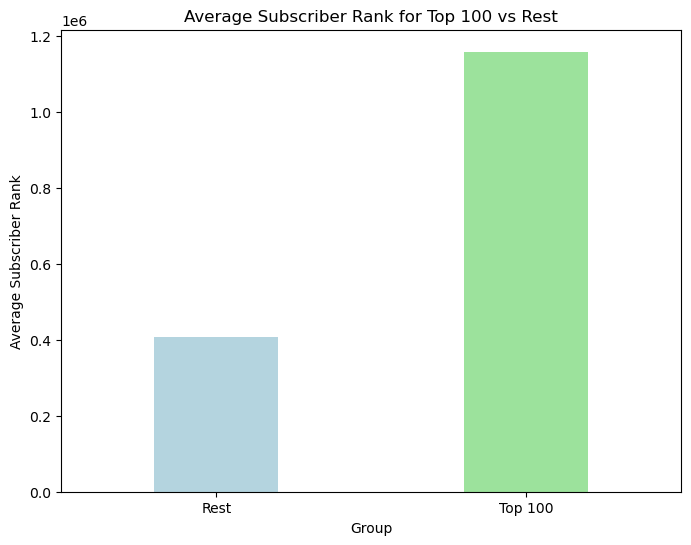

In [58]:
#This can be moved up, but it is not a need, want to see the average... 

top_df = agg_df_2[agg_df_2['channel_id'].isin(top_500_nodes)]

# Filter for the rest of the channels
rest_df = agg_df_2[agg_df_2['channel_id'].isin(rest_of_the_nodes)]

std_dev_top_top = top_df['subscribers_cc'].mean()
std_dev_rest_rest = rest_df['subscribers_cc'].mean()

# Add a 'Group' column to each DataFrame
top_df['Group'] = 'Top 100'
rest_df['Group'] = 'Rest'

# Combine the data into one DataFrame
combined_df = pd.concat([top_df, rest_df])

# Calculate the average subscriber rank for each group
combined_df = combined_df.groupby('Group')['subscribers_cc'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='Group', y='subscribers_cc', data=combined_df, capsize=0.1, palette=['lightblue','lightgreen'],width=0.4)

plt.title('Average Subscriber Rank for Top 100 vs Rest')
plt.ylabel('Average Subscriber Rank')
plt.xlabel('Group')
plt.savefig('Average_sub.png')

plt.show()